In [4]:
R.version.string
print("email: 'Maciek Sykulski'<macieksk@gmail.com>")
length(ls())

[1] "R version 3.2.0 (2015-04-16)"

[1] "email: 'Maciek Sykulski'<macieksk@gmail.com>"


[1] 0

In [ ]:
#install.packages("https://cran.r-project.org/src/contrib/rpca_0.2.3.tar.gz")

In [38]:
projDir<-"./"
projectPrefix<-"R_supervised_analysis_MP_cTCC_Project"

#
load.sources<-function(){
    for (f in  c("utils.R", #Contains inpar, save_new_image, etc
                 "heatmap.clust.R",
                 "Choi.et.al.genes.R",
                 "iterative.unsup.sup.R",
                 "clustcompare.R"
                 #"circos.R"
                 #...  
                 ) 
        ){
    source(paste(projDir,"/src/",f,sep=""))
   }
}
load.sources()

In [40]:
#Load project from .Rdata
#system.time(load(paste(projDir,"/r_saved_images/",projectPrefix,".Rdata",sep="")))
lsos(n=10)
gc()

,Type,Size,Rows,Columns
iterationLoop1000coeffstat300,list,1155935224,32,NA
abscoef2iterations,list,792769040,3,NA
iterationLoopOnlyCTCCPAM,list,759964408,19,NA
ima,array,712800208,6600,4500
iterationLoopOnlyCTCCCPAM,list,640275456,16,NA
iteration.states300,list,493176712,12,NA
iterationLoop1000fstat,list,400588056,11,NA
iterationLoop1000pamlike,list,325487736,9,NA
iterationLoop1000abscoef,list,284998808,8,NA
iteration.states_k2,list,237683040,6,NA


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,16052934.0,857.4,25102783.0,1340.7,25102783.0,1340.7
Vcells,602727244.0,4598.5,956279554.0,7295.9,847037498.0,6462.4


In [7]:
#Save project .Rdata
gc()
#system.time(save_new_image())

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,329183.0,17.6,592000.0,31.7,550603.0,29.5
Vcells,544411.0,4.2,1023718.0,7.9,785564.0,6.0


In [47]:
library(xlsx)
library(cluster)
library(MASS)

library(lumi)
library(lumiHumanIDMapping)
library(lumiHumanAll.db)

#install.packages("./src/mylimma_3.18.13.tar.gz")
# Modyfikowałem pakiet limma, bo był w nim bug, którego zgłosiłem.
# Może już jest poprawiony w nowej wersji?
library(limma)

library(rpca)

library(gplots)
library(png)

#library(multicore)
library(annotate)
library(GOstats)

library(pamr)
library(flare)

library(lattice)
library(multtest)
library(matrixStats)
library(extrafont)
library(enrichvs)
library(statmod)

load.sources()

#sessionInfo()

# Macierz ekspresji
Okej, w naszym projekcie dane o ekspresji pochodziły z mikromacierzy ekspresji i były wczytane pakietem lumi, a następnie znormalizowane przy użyciu odpowiedniej https://en.wikipedia.org/wiki/Variance-stabilizing_transformation VST (intensywności świecenia sond zostały przetransformowane czymś w rodzaju log2, ktory trochę inaczej traktuje małe wartości). 

● Variance Stabilization Transformation (VST): was performed by R &quot;lumi&quot; package
according to Lin, Simon M., et al. &quot;Model-based variance-stabilizing transformation for
Illumina microarray data.&quot; Nucleic acids research 36.2 (2008)

● This step is performed to remove undesirable dependency of intensity variance,
v, on the signal mean, and has similarities with log2 transform.

● Normalization: Robust Spline Normalization (RSN) was performed by R &quot;lumi&quot;
package. This step normalizes data between microarrays to have similar variance, and
the method is a hybrid approach between quantile and loess normalization.

Wynik tych operacji po wyrzuceniu niektórych próbek ze względu na quality control (o quality control jest w dokumentach i prezentacji, ktore Ci wyślę) jest w zmiennej `selDataMatrix`.

Podobną macierz pewnie stworzysz z danych RNA-seq, tylko, że będą w niej liczby odczytów, które trzeba jakoś znormalizować. Praca z danymi RNA-seq i pakietem `limma` jest opisana tutaj w rozdziale 15: https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf i są tam podane przykłady transformacji normalizujących. Wydaje mi się, że po takiej normalizacji Twoja macierz będzie mogła zostać analizowana w ten sam sposób jak `selDataMatrix`, co przedstawię poniżej.


In [16]:
dim(selDataMatrix)
selDataMatrix[1:2,1:5]

[1] 27645   151

,7656774068_A,7656774068_B,7656774068_C,7656774068_D,7656774068_E
Ku8QhfS0n_hIOABXuE,9.277933,10.807275,10.281965,8.637120,9.066208
fqPEquJRRlSVSfL.8A,8.235855,8.254479,8.191368,8.521740,8.467335


W `selDataMatrix` kolumny to próbki, a wiersze to sondy odpowiadające genom, zdażają się geny do których jest przypisane więcej niż jedna sonda/wiersz. Nazwy wierszy to nazwy sond, z których można w następujący sposób odczytać m.in. nazwy genów `geneSymbol`. U Ciebie nie będzie nazw sond, więc będziesz musiała sama dostarczyć te nazwy, bo są one używane przez niektóre funkcje.

Jednak dla działania limmy chyba dość istotne jest to, by nazwy wierszy w `selDataMatrix` były unikalne. Nazwy genów powinny być dostarczane przez funkcję mapującą ID wiersza na nazwę.

In [21]:
## Compute duplication number for genes
probeList <- rownames(selDataMatrix)
geneSymbol <- getSYMBOL(probeList, 'lumiHumanAll.db')
#length(geneSymbol)
cnts<-table(geneSymbol)
geneSymbolCounts<-data.frame(geneSymbol,probe.to.gene.count=cnts[geneSymbol],stringsAsFactors=FALSE)
head(geneSymbolCounts)
addmargins(table(geneSymbolCounts$probe.to.gene.count))

,geneSymbol,probe.to.gene.count
Ku8QhfS0n_hIOABXuE,MACC1,2
fqPEquJRRlSVSfL.8A,A1BG,1
x57Vw5B5Fbt5JUnQkI,A1CF,3
ritxUH.kuHlYqjozpE,A1CF,3
QpE5UiUgmJOJEkPXpc,A1CF,3
ZtOcIegchMOATSJScI,POTEH,2



    1     2     3     4     5     6     7     8   Sum 
13793  7080  4644  1556   430    78    35    16 27632 

Tak jak widać powyżej, są i geny, do których pasuje nawet 8 wierszy.

Poza tym próbki (kolumny) były podzielone na 2 grupy różniące się typem raka pęcherza w następujący sposób:

In [26]:
summary(orig.sample.labels)

Micropap Conv.TCC 
      41      110

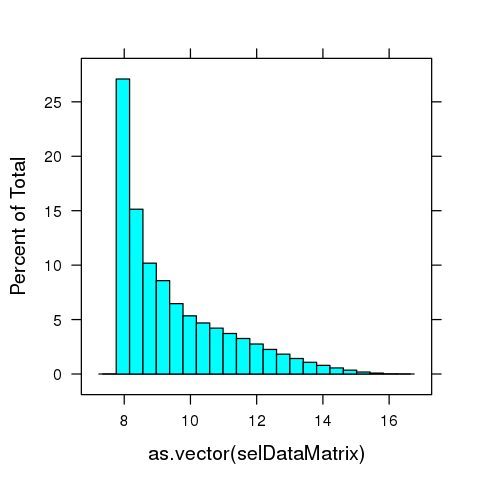

In [23]:
options(repr.plot.width=4, repr.plot.height=4)
options(jupyter.plot_mimetypes = 'image/png')
# Histogram znormalizowanych danych
histogram(~as.vector(selDataMatrix))

# Podstawowa analiza limma

Czyli wybór top N genów różnicujących przy danym klastrowaniu, tfu, przepraszam, grupowaniu próbek.

In [43]:
length(orig.sample.labels)
dim(selDataMatrix)

[1] 151

[1] 27645   151

In [9]:
sampleType <- orig.sample.labels
design <- model.matrix(~ sampleType)
colnames(design)

[1] "(Intercept)"        "sampleTypeConv.TCC"

In [10]:
#Tricky to get the right sample type: reverse the indicator column
design[,2]<-1-design[,2]
colnames(design)[2]<-"Micropap"

In [11]:
head(design)
table(design[,1])
table(design[,2])

,(Intercept),Micropap
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1



  1 
151 


  0   1 
110  41 

In [96]:
#?rlm

In [ ]:
system.time(fit <- lmFit(selDataMatrix, design,method="robust", maxit = 50))
system.time(fit <- eBayes(fit))

Warning message:
In rlm.default(x = X, y = y, weights = w, ...): 'rlm' failed to converge in 50 stepsWarning message:
In rlm.default(x = X, y = y, weights = w, ...): 'rlm' failed to converge in 50 stepsWarning message:
In rlm.default(x = X, y = y, weights = w, ...): 'rlm' failed to converge in 50 stepsWarning message:
In rlm.default(x = X, y = y, weights = w, ...): 'rlm' failed to converge in 50 stepsWarning message:
In rlm.default(x = X, y = y, weights = w, ...): 'rlm' failed to converge in 50 stepsWarning message:
In rlm.default(x = X, y = y, weights = w, ...): 'rlm' failed to converge in 50 stepsWarning message:
In rlm.default(x = X, y = y, weights = w, ...): 'rlm' failed to converge in 50 stepsWarning message:
In rlm.default(x = X, y = y, weights = w, ...): 'rlm' failed to converge in 50 stepsWarning message:
In rlm.default(x = X, y = y, weights = w, ...): 'rlm' failed to converge in 50 steps

In [ ]:
class(fit)
names(fit[1])

In [ ]:
names(fit)
head(fit$coefficients)

In [ ]:
## Add gene symbols to gene properties
geneSymbol <- getSYMBOL(probeList, 'lumiHumanAll.db')
geneName <- sapply(lookUp(probeList, 'lumiHumanAll.db', 'GENENAME'), function(x) x[1])
fit$genes <- data.frame(ID= probeList, geneSymbol=geneSymbol, geneName=geneName, stringsAsFactors=FALSE)

In [ ]:
#?topTable
#
#sort.by: character string specifying statistic to rank genes by.
#          Possible values for ‘topTable’ and ‘toptable’ are ‘"logFC"’,
#          ‘"AveExpr"’, ‘"t"’, ‘"P"’, ‘"p"’, ‘"B"’ or ‘"none"’.
#          (Permitted synonyms are ‘"M"’ for ‘"logFC"’, ‘"A"’ or
#          ‘"Amean"’ for ‘"AveExpr"’, ‘"T"’ for ‘"t"’ and ‘"p"’ for
#          ‘"P"’.)  Possibilities for ‘topTableF’ are ‘"F"’ or ‘"none"’.
#
#The ‘sort.by’ argument specifies the criterion used to select the
#     top genes. The choices are: ‘"logFC"’ to sort by the (absolute)
#     coefficient representing the log-fold-change; ‘"A"’ to sort by
#     average expression level (over all arrays) in descending order;
#     ‘"T"’ or ‘"t"’ for absolute t-statistic; ‘"P"’ or ‘"p"’ for
#     p-values; or ‘"B"’ for the ‘lods’ or B-statistic.

Wybór 1500 najważniejszych genów, sortowanych po współczynnikach z modeli liniowych odpowiadających log-FoldChange, 
czyli zmianie intensywności. Wyliczane jest False Discovery Rate adjusted p-value (czasem chyba zwane q-value).

In [ ]:
ttab<-topTable(fit, coef='Micropap', adjust='fdr', number=1500,sort.by="M")

ttab<-ttab[ttab$adj.P.Val<0.01,]  #Filter out based on weak FDR q-values
NROW(ttab)
#Since IDs are the same as rows, we add ENTREZ genes ids basing on them
ttab<-cbind(ttab,entrezID=unlist(lookUp(ttab$ID,'lumiHumanAll.db','ENTREZID')))

print("AbsLogFoldChange summary:")
summary(abs(ttab$logFC))
print("Quantile ")
quantile(abs(ttab$logFC),0.05)
print("LogFoldChange summary:")
summary(ttab$logFC)
print("log(Adj.PVal) summary:")
summary(log(ttab$adj.P.Val))
print("Quantile ")
quantile(log(ttab$adj.P.Val),0.95)

In [124]:
ttabUp<-ttab[ttab$logFC>0,]
ttabDown<-ttab[ttab$logFC<0,]
NROW(ttabUp)
NROW(ttabDown)
summary(log(ttabUp$adj.P.Val))
summary(log(ttabDown$adj.P.Val))

print("LogFoldChange summary:")
summary(ttabUp$logFC)
summary(ttabDown$logFC)

[1] 901

[1] 577

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-123.500  -37.710  -25.520  -28.770  -16.080   -4.866 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-135.600  -28.240  -19.160  -21.540  -13.300   -4.671 

[1] "LogFoldChange summary:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8238  0.9399  1.0970  1.1990  1.3360  3.3170 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.3570 -1.2120 -1.0140 -1.1010 -0.9104 -0.8235 

In [125]:
#Significant logFoldChanges
sum(ttab$logFC>1)
sum(ttab$logFC< (-1))

[1] 587

[1] 309

In [126]:
names(ttab)

[1] "ID"         "geneSymbol" "geneName"   "logFC"      "AveExpr"   
 [6] "t"          "P.Value"    "adj.P.Val"  "B"          "entrezID"

In [127]:
with(ttabUp[ttabUp$logFC>1,],{
#print(head(sort(geneSymbol)))
write.table(sort(geneSymbol),file=plotName("topGenes_FC_upreg_gt1_alpha.txt"),quote=FALSE,row.names=FALSE,col.names=FALSE)
})
plotName("topGenes_FC_upreg_gt1_alpha.txt")

[1] "R_supervised_analysis_MP_cTCC_Project_topGenes_FC_upreg_gt1_alpha.txt"

In [128]:
with(ttabUp[ttabUp$logFC>1,],{
or<-order(-logFC)
print(head(cbind(entrezID,logFC)[or,]))
write.table(entrezID[or],file=plotName("topGenes_FC_upreg_gt1_FCsort.txt"),quote=FALSE,row.names=FALSE,col.names=FALSE)
})
plotName("topGenes_FC_upreg_gt1_FCsort.txt")

     entrezID    logFC
[1,]      525 3.316740
[2,]      544 2.760992
[3,]      164 2.709186
[4,]      800 2.692823
[5,]       12 2.679728
[6,]     1025 2.542547


[1] "R_supervised_analysis_MP_cTCC_Project_topGenes_FC_upreg_gt1_FCsort.txt"

In [129]:
with(ttabDown[ttabDown$logFC<(-1),],{
print(head(sort(geneSymbol)))
write.table(sort(geneSymbol),file=plotName("topGenes_FC_downreg_gt1_alpha.txt"),quote=FALSE,row.names=FALSE,col.names=FALSE)
})
plotName("topGenes_FC_downreg_gt1_alpha.txt")

[1] "ABCA3"  "ABHD12" "ACACB"  "ACKR2"  "ACOT11" "ACP6"  


[1] "R_supervised_analysis_MP_cTCC_Project_topGenes_FC_downreg_gt1_alpha.txt"

In [130]:
with(ttabDown[ttabDown$logFC<(-1),],{
or<-order(logFC)
print(head(cbind(geneSymbol,logFC)[or,]))
write.table(geneSymbol[or],file=plotName("topGenes_FC_downreg_gt1_FCsort.txt"),quote=FALSE,row.names=FALSE,col.names=FALSE)
})
plotName("topGenes_FC_downreg_gt1_FCsort.txt")

     geneSymbol logFC              
[1,] "PROM1"    "-3.35687081616985"
[2,] "IGDCC3"   "-3.04184512900755"
[3,] "TRPV6"    "-2.69033620295423"
[4,] "MUC1"     "-2.33872541712067"
[5,] "MESP1"    "-2.23612499010657"
[6,] "CLDN3"    "-2.17693188842061"


[1] "R_supervised_analysis_MP_cTCC_Project_topGenes_FC_downreg_gt1_FCsort.txt"

# GO ontology
Mam też kod używający pakiety require(GOstats), który generował istotnie reprezentowane GO terms w zbiorze top genów. Powiedz, jeśli jesteś zainteresowana.

#Podstawowe heatmapy

Funkcja, która rysuje heatmapy wybranego podzbioru genów klastruje wiersze i kolumny macierzy. Klastrowanie można ew. wymusić na własne. Klastrowanie odbywa się, przy użyciu kilku(dziesięciu) największych wartości singularnych z rozkładu, który przypomina rozkład SVD, tylko, że odporny na outliery (RobustPCA - więcej o metodzie w prezentacji). Poza tym niektóre geny są zaznaczane na kolorowo, wg kodu kolorów (z pliku "src/Choi.et.al.genes.R"). Wykres można zrobić w 2 wersjach: jeden panel, tylko macierz ekspresji, lub 3 panele obrazujące rozkład RobustPCA.

Gdybyś potrzebowała dopieścić obrazek, to pytaj, trzeba kombinować opcjami hm.hprop itp.


In [33]:
load.sources()
N<-100

pname<-paste("plots/",plotName(paste("heatmap_top",N,"_example1.png",sep="")),sep="")

res<-with(ttab[1:min(N,NROW(ttab)),],{
     
     genedata<-selDataMatrix[ID,]
     
     heatmap.clust(pname,genedata,geneSymbol,
                   pca.type="robust.pca",#pca.type="svd",                   
                   plot.only.raw=TRUE, # only 1 or 3 panels 
                   dend.both=TRUE, # dendrograms
                   #nv=length, #select all singular values
                   nv=function(d){d2<-d^2   # select as many singular values so their sum is over 0.XXX total sum
                                  cs<-cumsum(d2/sum(d2))
                                  head(which(cs>=0.999),1) 
                                  },
                   main.title="log(FoldChange) relative to median gene expression",
                   #sample.labels=c("violet","lightblue","green","purple")[sample.labels],
                   #sample.labels.marks=orig.sample.labels=="Micropap",
                   sample.labels=c("violet","lightblue")[orig.sample.labels],
                   sample.labels.marks=suspicious.samples,#sample.labels==1,
                   gene.colors=get.color.for.gene(geneSymbol), # defined in "src/Choi.et.al.genes.R"
                   centralize=TRUE, #Median centralize        
                   normalize=FALSE, 
                   normalize.for.plot=FALSE, # for plot, but not for clustering
                   do.plot=TRUE,
                   clustering.distance="angular",
                   absolute.gene.clustering=FALSE,
                   rect.column=3,
                   rect.row=2,
                   sample.method="ward",
                   genes.method="ward",
                   hm.width=2000,
                   hm.height=1200,
                   hm.hprop=c(2,1,10))
})
pname

Note: no visible global function definition for 'gpuSvd' 
Note: no visible global function definition for 'gpuMatMult' 
[1] "rpca converged: TRUE in:"
   user  system elapsed 
  1.190   0.010   1.176 
            robust.rank rank.used.in.clustering 
                     57                      41 


Warning message:
In acos(corgi): NaNs producedWarning message:
In acos(corpi): NaNs produced

[1] 151  41 100  41


[1] "plots/R_supervised_analysis_MP_cTCC_Project_heatmap_top100_example1.png"

<img src='plots/R_supervised_analysis_MP_cTCC_Project_heatmap_top100_example1.png'>

In [37]:
load.sources()
N<-200

pname<-paste("plots/",plotName(paste("heatmap_top",N,"_example2_wide.png",sep="")),sep="")

res<-with(ttab[1:min(N,NROW(ttab)),],{
     
     genedata<-selDataMatrix[ID,]
     
     heatmap.clust(pname,genedata,geneSymbol,
                   pca.type="robust.pca",#pca.type="svd",                   
                   plot.only.raw=FALSE, # only 1 or 3 panels 
                   dend.both=TRUE, # dendrograms
                   #nv=length, #select all singular values
                   nv=function(d){d2<-d^2   # select as many singular values so their sum is over 0.XXX total sum
                                  cs<-cumsum(d2/sum(d2))
                                  head(which(cs>=0.999),1) 
                                  },
                   main.title="log(FoldChange) relative to median gene expression",
                   #sample.labels=c("violet","lightblue","green","purple")[sample.labels],
                   #sample.labels.marks=orig.sample.labels=="Micropap",
                   sample.labels=c("violet","lightblue")[orig.sample.labels],
                   sample.labels.marks=suspicious.samples,#sample.labels==1,
                   gene.colors=get.color.for.gene(geneSymbol), # defined in "src/Choi.et.al.genes.R"
                   centralize=TRUE,        
                   normalize=FALSE,
                   normalize.for.plot=FALSE,                   
                   do.plot=TRUE,
                   clustering.distance="angular",
                   absolute.gene.clustering=FALSE,
                   rect.column=3,
                   rect.row=2,
                   sample.method="ward",
                   genes.method="ward",
                   hm.width=2200,
                   hm.height=2200,
                   hm.hprop=c(2,1,20))
})
pname

Note: no visible global function definition for 'gpuSvd' 
Note: no visible global function definition for 'gpuMatMult' 
[1] "rpca converged: TRUE in:"
   user  system elapsed 
  3.050   0.120   2.707 
            robust.rank rank.used.in.clustering 
                     85                      61 


Warning message:
In acos(corgi): NaNs producedWarning message:
In acos(corpi): NaNs produced

[1] 151  61 200  61


[1] "plots/R_supervised_analysis_MP_cTCC_Project_heatmap_top200_example2_wide.png"

A tak wygląda w szczegółach rozkład RobustPCA (kliknij prawym i otwórz w nowej zakładce)
<img src='plots/R_supervised_analysis_MP_cTCC_Project_heatmap_top200_example2_wide.png'>

# Iteracyjne poprawianie klastrowania

Nie wiem, czy to Ci się przyda, ale w naszym projekcie wykonaliśmy następującą procedurę.
Na początku mieliśmy dane klastrowanie próbek na 2 klastry. Po pierwsze, podejrzewaliśmy, że to klastrowanie nie jest idealne (próbki mogły być źle sklasyfikowane), po drugie hipotezą było istnienie więcej niż 2 podtypów raka, co najmniej 4. Dlatego wykonaliśmy iteracyjnie:
1.znajdź top 1000 najważniejszych genów dla bieżacego klastrowania
(sortując po sumie kwadratów współczynników dla każdego z klastrów)
2.znajdź nowe klastrowanie na próbkach na k=4 klastrów używając do tego tych genów
3.jeśli klastrowanie różni się od poprzedniego GOTO 1

W praktyce klastrowanie i wybór genów stabilizowało się po kilku/kilkunastu iteracjach i pozwoliło odkryć podział na 4 grupy pacjentów. Po przyporządkowaniu tych grup patrząc na genach, które w nich ulegają ekspresji mogliśmy nazwać te grupy. Następnie mogliśmy później wybrać geny, które są ważne *tylko* dla pewnych 2 klastrów.

In [ ]:
load.sources()
inpar(iterationLoop1000abscoef,
#iterationLoop1000rerun<-eval(
expression({
  #perform.iterative.clustering(iterationLoop1000coeffstat300,
  iterative.clustering(
    selDataMatrix,
    sample.labels=orig.sample.labels,                      
    N=1000, k=4, 
    gene.order="abscoef",
    p.abscoef=2,  
    #coef.fstat.pvweight=300,
    plotname.core="abscoefstart_lfc1.5",#match.arg(gene.order),
    maxit=32,
    #startit=24,
    avail.colors=c("violet","lightblue","green","purple","red","yellow"),
    sample.labels.marks=orig.sample.labels=="Micropap",
    pval.threshold=0.005,
    lfc.threshold=log2(1.5),
    explained.variance.for.clustering.thr=0.999,
    obligatory.genes=obligatory.genes
    )
}))

In [44]:
#

In [41]:
itstate<-last(iterationLoop1000abscoef)
sample.labels<-itstate$sample.labels
k<-length(levels(factor(sample.labels)))

ttab<-select.genes.from.log.odds(last(iterationLoop1000abscoef),all.col=2:4,to.sel.col=2)
NROW(ttab)

Nsel<-20
#ttab<-itstate$ttab
ttab<-ttab[ttab$adj.P.Val<0.005,]
NROW(ttab)
ttab<-ttab[order(abs(ttab$cluster.2)^2,decreasing=TRUE),]
#ttab<-ttab[order(0.7*abs(ttab$cluster.2)^2-(abs(ttab$cluster.3)^2+abs(ttab$cluster.4)^2),decreasing=TRUE),]

obid<-which(ttab$ID%in%obligatory.genes)
obid<-obid[obid<500]
ttab[obid[obid<=Nsel],"geneSymbol"]
ttab[obid[obid>Nsel],"geneSymbol"]
ttab<-rbind(ttab[obid,],ttab[-obid,])
N<-Nsel+length(obid)-sum(obid<=Nsel)

[1] 1896

[1] 1896

character(0)

[1] "MT2A"    "ERBB2"   "TBX2"    "ALOX5AP" "EMP3"

In [42]:
load.sources()
pname<-paste("plots/",plotName(paste("heatmap_top",N,"_from_top1000abscoef_k",k,"_minpval0.005.png",sep="")),sep="")

hmplot<-with(ttab[1:min(N,NROW(ttab)),],{
     
     genedata<-selDataMatrix[ID,]
     
     heatmap.clust(pname,genedata,geneSymbol,
                   pca.type="robust.pca",#pca.type="svd",                   
                   plot.only.raw=TRUE,
                   dend.both=TRUE,
                   nv=length,
                   #nv=function(d){d2<-d^2
                   #               cs<-cumsum(d2/sum(d2))
                   #               head(which(cs>=0.999),1)
                   #               },
                   main.title="log(FoldChange) relative to median gene expression",
                   #sample.labels=c("violet","lightblue","green","purple")[sample.labels],
                   #sample.labels.marks=orig.sample.labels=="Micropap",
                   sample.labels=c("violet","lightblue")[orig.sample.labels],
                   sample.labels.marks=suspicious.samples,#sample.labels==1,
                   gene.colors=get.color.for.gene(geneSymbol),
                   centralize=TRUE,        
                   normalize=FALSE,
                   normalize.for.plot=FALSE,                   
                   do.plot=TRUE,
                   clustering.distance="angular",
                   absolute.gene.clustering=FALSE,
                   rect.column=3,
                   rect.row=2,
                   sample.method="ward",
                   genes.method="ward",
                   hm.width=2000,
                   hm.height=1200,
                   hm.hprop=c(2,1,10))
})
pname

[1] "rpca converged: TRUE in:"
   user  system elapsed 
  0.280   0.000   0.278 
            robust.rank rank.used.in.clustering 
                     13                      13 


Warning message:
In acos(corgi): NaNs producedWarning message:
In acos(corpi): NaNs produced

[1] 151  13  25  13


[1] "plots/R_supervised_analysis_MP_cTCC_Project_heatmap_top25_from_top1000abscoef_k4_minpval0.005.png"

<img src='plots/R_supervised_analysis_MP_cTCC_Project_heatmap_top25_from_top1000abscoef_k4_minpval0.005.png'>

In [48]:
#Save table of 1000 genes with clusterings to Excel file
df<-genes.cluster.table.save(plotName("genes_table_top1000_abscoef"),
                             tail(iterationLoop1000abscoef,1)[[1]],1000,4,k.genes=18)

[1] 1000
         1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1 
                                        59 
         1.1.1.1.1.1.1.1.1.1.3.3.3.3.3.3.3 
                                        50 
   1.1.1.1.1.1.1.7.8.8.9.10.10.10.10.10.10 
                                        60 
1.1.1.1.1.1.8.9.10.11.12.13.14.14.15.16.16 
                                        37 
      1.1.1.1.5.5.5.5.6.6.7.8.8.8.12.12.12 
                                        20 
       1.1.1.1.5.5.5.5.6.6.7.8.8.8.8.15.15 
                                        22 
         1.1.1.1.5.5.5.5.6.6.7.8.8.8.8.8.8 
                                        45 
     1.1.4.5.6.6.6.6.7.7.8.9.9.15.16.17.17 
                                        89 
         1.1.4.5.6.6.6.6.7.7.8.9.9.9.9.9.9 
                                        66 
  1.1.4.5.6.7.7.8.9.9.10.11.11.11.11.11.11 
                                        49 
         2.2.2.2.2.2.2.2.2.2.2.2.2.2.2.2.2 
                                        91 
        2.2.2.2.2.2.2.2

`R_supervised_analysis_MP_cTCC_Project_genes_table_top1000_abscoef_top1000_k4.xls`

png 
  3

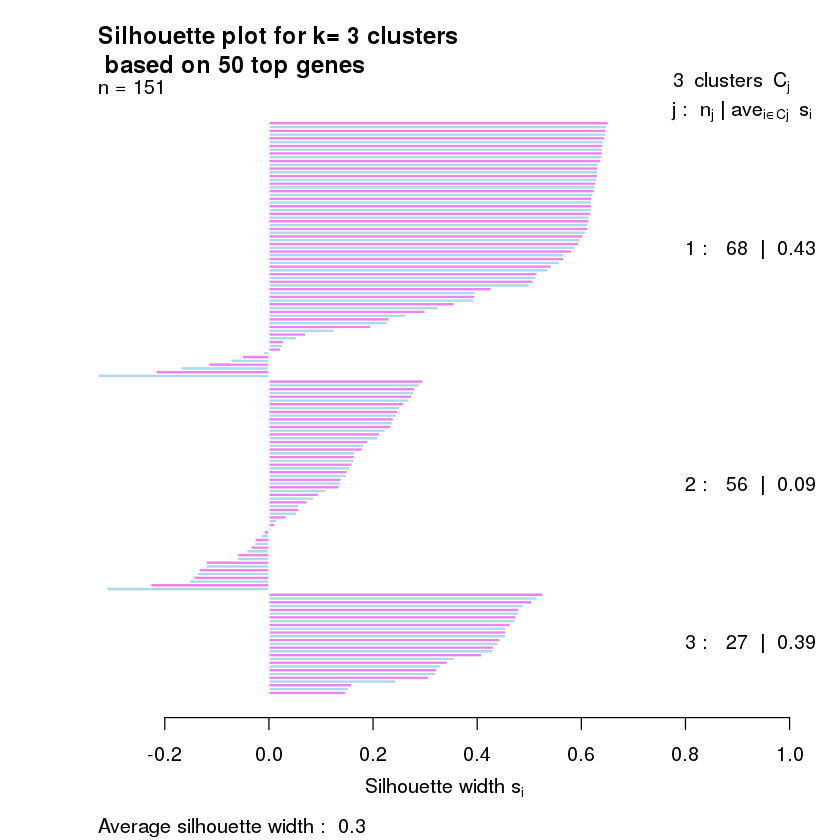

In [52]:
load.sources()
silhouette.for.hmplot(res$hmplot,50,3,col=c("violet","lightblue"))#,"green"))
                    #sub=paste("ConvTCC, N.total =",
                    #          NCOL(as.matrix(tail(iterationLoopOnlyCTCCCPAM,1)[[1]]$hmplot[[1000]]$pi.dist))
                    #          ))
dev.off()

In [56]:
load.sources()

#itstate<-last(iterationLoop1000abscoef)
itstate<-last(iterationLoopALLabscoef)
#itstate<-iteration.states[[1]]
#itstate<-tail(iterationLoop1000fstat,1)[[1]]

sample.labels<-orig.sample.labels
#sample.labels<-itstate$sample.labels

#N<-1000
N<-300
#N<-Inf

#k<-4
k<-length(levels(factor(sample.labels)))

ext<-"png"
#hclustfun=function(x)hclust(dist(coefs[,2]),method="ward"),
#pname<-plotName(paste("heatmap_top20_from_top",N,"_k",k,"_minpval0.001.png",sep=""))
pname<-plotName(paste("heatmap_top",N,"_k",k,".",ext,sep=""))

ttab<-itstate$ttab

In [60]:
#As above but plot only raw data column
load.sources()

#ext<-"eps"
ext<-"png"
pname<-paste("plots/",plotName(paste("heatmap_top",N,"_k",k,".",ext,sep="")),sep="")


res<-with(ttab[1:min(N,NROW(ttab)),],{     
     genedata<-selDataMatrix[ID,]

     htclust<-heatmap.clust(pname,genedata,geneSymbol,
                   pca.type="robust.pca",#pca.type="svd",                   
                   plot.only.raw=TRUE,
                   dend.both=TRUE,
                   #nv=length,
                   nv=function(d){d2<-d^2
                                  cs<-cumsum(d2/sum(d2))
                                  head(which(cs>=0.999),1)
                                  },
                   main.title="log(FoldChange) relative to median gene expression",
                   sample.labels=c("violet","lightblue","green","purple")[sample.labels],
                   sample.labels.marks=orig.sample.labels=="Micropap",
                   #sample.labels=c("violet","lightblue")[orig.sample.labels],
                   #sample.labels.marks=suspicious.samples,#sample.labels==1,
                   gene.colors=get.color.for.gene(geneSymbol),
                   centralize=TRUE,        
                   normalize=FALSE,
                   normalize.for.plot=FALSE,                   
                   do.plot=TRUE,                   
                   absolute.gene.clustering=FALSE,
                   #rect.column=3,
                   #rect.row=2,
                   sample.method="ward",
                   genes.method="ward",
                   create.device=ext,
                   col.order=-as.integer(sample.labels)
                   #hm.width=2000,
                   #hm.height=1200,
                   #hm.hprop=c(2,1,10)
                  )
    
#     df<-genes.cluster.table.save(paste(pname,".xls",sep=""),
#                             itsate,#last(iterationLoopALLabscoef),
#                             N=NROW(ttab),k.genes=8,
#                             ttab=ttab,hmplot=htclust$hmplot)

     htclust
})
pname

[1] "rpca converged: TRUE in:"
   user  system elapsed 
  14.97    1.31   12.32 
            robust.rank rank.used.in.clustering 
                     86                      59 


Warning message:
In acos(corgi): NaNs producedWarning message:
In acos(corpi): NaNs produced

[1] 151  59 300  59


[1] "plots/R_supervised_analysis_MP_cTCC_Project_heatmap_top300_k2.png"

<img src='plots/R_supervised_analysis_MP_cTCC_Project_heatmap_top300_k2.png'>